# Импортируем необходимые библиотеки


In [ ]:
!pip install arch
!pip install statsmodels

# DEBUG
!pip install -Uqq ipdb

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle
from sklearn.preprocessing import MinMaxScaler
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame

# DEBUG
import ipdb

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

# Загрузим датасет


In [ ]:
df_initial = pd.read_csv('data_full.csv', parse_dates=[0])
df_initial = df_initial.drop(columns=['Medics per 10k', 'Oftalmologi per 10k', 'Alcohol use'])
df_initial

,Year,Total population,City population,Village population,Support,Education,Health,Social,Real money,Low money,...,Against economy,Victims prop,Internet used for federal services prop,Internet used for MFC prop,Got result prop,Internet used total prop,15-72 prop,VRP,"Consumption, rub","VRP index, %"
0,2016-01-01,4236.0,2872.1,1363.9,10.1,23.4,27.7,17.0,96.7,14.2,...,2960.0,2.6,42.2,35.7,56.6,78.1,82.7,324802.1,313200.7,103.3
1,2017-01-01,4231.3,2874.0,1357.3,11.4,24.1,21.0,21.9,100.6,13.9,...,2265.0,2.9,48.7,34.8,66.1,80.0,85.0,341163.4,328334.0,102.7
2,2018-01-01,4220.4,2871.4,1349.0,9.7,27.4,26.0,23.7,102.3,13.2,...,2178.0,2.9,60.1,30.7,78.4,82.3,88.3,367627.9,349235.6,102.5
3,2019-01-01,4202.3,2863.7,1338.6,9.6,24.5,24.2,20.6,101.2,13.3,...,2064.0,3.1,59.3,28.5,80.4,83.3,89.4,389521.4,361083.1,102.1
4,2020-01-01,4197.8,2862.9,1334.9,10.1,22.5,26.0,23.1,98.6,13.0,...,1866.0,3.0,60.9,25.3,86.3,87.6,90.9,409240.7,368512.4,97.8
5,2021-01-01,4181.5,2850.8,1330.7,9.3,21.8,26.0,22.1,103.5,12.0,...,3396.0,3.0,72.2,24.2,90.9,88.0,91.1,483970.4,427258.2,106.8
6,2022-01-01,4192.3,2845.4,1346.9,10.1,22.3,22.3,23.3,100.7,10.5,...,3509.0,3.0,76.3,22.3,93.9,91.4,94.5,483970.4,427258.2,106.8


In [ ]:
# Переиеменуем Year на Date
df_initial = df_initial.rename(columns={'Year': 'Date'})

In [ ]:
# Установим Date в качестве индекса и посмотрим что получилось
df_initial = df_initial.set_index('Date')
df_initial

,Total population,City population,Village population,Support,Education,Health,Social,Real money,Low money,Mean money,...,Against economy,Victims prop,Internet used for federal services prop,Internet used for MFC prop,Got result prop,Internet used total prop,15-72 prop,VRP,"Consumption, rub","VRP index, %"
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,4236.0,2872.1,1363.9,10.1,23.4,27.7,17.0,96.7,14.2,26655.4,...,2960.0,2.6,42.2,35.7,56.6,78.1,82.7,324802.1,313200.7,103.3
2017-01-01,4231.3,2874.0,1357.3,11.4,24.1,21.0,21.9,100.6,13.9,27741.4,...,2265.0,2.9,48.7,34.8,66.1,80.0,85.0,341163.4,328334.0,102.7
2018-01-01,4220.4,2871.4,1349.0,9.7,27.4,26.0,23.7,102.3,13.2,29097.1,...,2178.0,2.9,60.1,30.7,78.4,82.3,88.3,367627.9,349235.6,102.5
2019-01-01,4202.3,2863.7,1338.6,9.6,24.5,24.2,20.6,101.2,13.3,30865.8,...,2064.0,3.1,59.3,28.5,80.4,83.3,89.4,389521.4,361083.1,102.1
2020-01-01,4197.8,2862.9,1334.9,10.1,22.5,26.0,23.1,98.6,13.0,31519.4,...,1866.0,3.0,60.9,25.3,86.3,87.6,90.9,409240.7,368512.4,97.8
2021-01-01,4181.5,2850.8,1330.7,9.3,21.8,26.0,22.1,103.5,12.0,35049.7,...,3396.0,3.0,72.2,24.2,90.9,88.0,91.1,483970.4,427258.2,106.8
2022-01-01,4192.3,2845.4,1346.9,10.1,22.3,22.3,23.3,100.7,10.5,40008.0,...,3509.0,3.0,76.3,22.3,93.9,91.4,94.5,483970.4,427258.2,106.8


In [ ]:
# Получим список названий всех колонок кроме колонки Date
labels = df_initial.columns.tolist()
labels

In [ ]:
# Функция MinMax нормализации
def normalize(df: DataFrame) -> (DataFrame, MinMaxScaler):
  scaler = MinMaxScaler()
  df_normalized = df.copy()
  numeric_columns = df.select_dtypes(include=['number']).columns
  df_normalized[numeric_columns] = scaler.fit_transform(df[numeric_columns])
  return (df_normalized, scaler)

In [ ]:
# Нормализуем все значения при помощи MinMaxScaler
df, scaler = normalize(df_initial)

In [ ]:
# Посмотрим на измененный датафрейм
df

,Total population,City population,Village population,Support,Education,Health,Social,Real money,Low money,Mean money,...,Against economy,Victims prop,Internet used for federal services prop,Internet used for MFC prop,Got result prop,Internet used total prop,15-72 prop,VRP,"Consumption, rub","VRP index, %"
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1.000000,0.933566,1.000000,0.380952,0.285714,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.665855,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.611111
2017-01-01,0.913761,1.000000,0.801205,1.000000,0.410714,0.000000,0.731343,0.573529,0.918919,0.081332,...,0.242848,0.6,0.190616,0.932836,0.254692,0.142857,0.194915,0.102792,0.132681,0.544444
2018-01-01,0.713761,0.909091,0.551205,0.190476,1.000000,0.746269,1.000000,0.823529,0.729730,0.182863,...,0.189897,0.6,0.524927,0.626866,0.584450,0.315789,0.474576,0.269060,0.315936,0.522222
2019-01-01,0.381651,0.639860,0.237952,0.142857,0.482143,0.477612,0.537313,0.661765,0.756757,0.315324,...,0.120511,1.0,0.501466,0.462687,0.638070,0.390977,0.567797,0.406609,0.419809,0.477778
2020-01-01,0.299083,0.611888,0.126506,0.380952,0.125000,0.746269,0.910448,0.279412,0.675676,0.364274,...,0.000000,0.8,0.548387,0.223881,0.796247,0.714286,0.694915,0.530499,0.484946,0.000000
2021-01-01,0.000000,0.188811,0.000000,0.000000,0.000000,0.746269,0.761194,1.000000,0.405405,0.628664,...,0.931223,0.8,0.879765,0.141791,0.919571,0.744361,0.711864,1.000000,1.000000,1.000000
2022-01-01,0.198165,0.000000,0.487952,0.380952,0.089286,0.194030,0.940299,0.588235,0.000000,1.000000,...,1.000000,0.8,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Убедимся что изначальный датафрейм не поврежден
df_initial

,Total population,City population,Village population,Support,Education,Health,Social,Real money,Low money,Mean money,...,Against economy,Victims prop,Internet used for federal services prop,Internet used for MFC prop,Got result prop,Internet used total prop,15-72 prop,VRP,"Consumption, rub","VRP index, %"
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,4236.0,2872.1,1363.9,10.1,23.4,27.7,17.0,96.7,14.2,26655.4,...,2960.0,2.6,42.2,35.7,56.6,78.1,82.7,324802.1,313200.7,103.3
2017-01-01,4231.3,2874.0,1357.3,11.4,24.1,21.0,21.9,100.6,13.9,27741.4,...,2265.0,2.9,48.7,34.8,66.1,80.0,85.0,341163.4,328334.0,102.7
2018-01-01,4220.4,2871.4,1349.0,9.7,27.4,26.0,23.7,102.3,13.2,29097.1,...,2178.0,2.9,60.1,30.7,78.4,82.3,88.3,367627.9,349235.6,102.5
2019-01-01,4202.3,2863.7,1338.6,9.6,24.5,24.2,20.6,101.2,13.3,30865.8,...,2064.0,3.1,59.3,28.5,80.4,83.3,89.4,389521.4,361083.1,102.1
2020-01-01,4197.8,2862.9,1334.9,10.1,22.5,26.0,23.1,98.6,13.0,31519.4,...,1866.0,3.0,60.9,25.3,86.3,87.6,90.9,409240.7,368512.4,97.8
2021-01-01,4181.5,2850.8,1330.7,9.3,21.8,26.0,22.1,103.5,12.0,35049.7,...,3396.0,3.0,72.2,24.2,90.9,88.0,91.1,483970.4,427258.2,106.8
2022-01-01,4192.3,2845.4,1346.9,10.1,22.3,22.3,23.3,100.7,10.5,40008.0,...,3509.0,3.0,76.3,22.3,93.9,91.4,94.5,483970.4,427258.2,106.8


In [ ]:
# Создадим список интересующих нас признаков для тестов
targets = ['Total population', 'City population', 'Village population']
df[targets]

,Total population,City population,Village population
Date,,,
2016-01-01,1.000000,0.933566,1.000000
2017-01-01,0.913761,1.000000,0.801205
2018-01-01,0.713761,0.909091,0.551205
2019-01-01,0.381651,0.639860,0.237952
2020-01-01,0.299083,0.611888,0.126506
2021-01-01,0.000000,0.188811,0.000000
2022-01-01,0.198165,0.000000,0.487952


In [ ]:
# Разделим данные на обучение и тесты
start = dt.datetime(2016,1,1)
split_date = dt.datetime(2022,1,1)
end = dt.datetime(2022,1,1)
next = dt.datetime(2023,1,1)

In [ ]:
# Объявим пустые словари полученных значений для наших моделей
forecasted_values = {
    'arima': {},
    'arch': {},
    'garch': {}
}

In [ ]:
# Нам потребуются полученные модели для работы сервиса
trained_arima_models = {}

### Обучим каждую модель для каждого признака и посмотрим результат

In [ ]:
# ARIMA
for column in labels:
  model = ARIMA(df[column], order=[5, 1, 0])
  result = model.fit()
  forecast = result.forecast(steps=10)
  forecasted_value = forecast.values.tolist()
  forecasted_values['arima'][column] = forecasted_value
  trained_arima_models[column] = result

In [ ]:
# ARCH
for column in labels:
  model = arch_model(df[column], vol='ARCH', mean='AR', dist='t')
  result = model.fit(last_obs=split_date)
  forecasts = result.forecast(horizon=3, start=split_date)
  forecasted_value = forecast.values.tolist()
  forecasted_values['arch'][column] = forecasted_value

In [ ]:
# GARCH
for column in labels:
  model = arch_model(df[column], vol='GARCH', mean='AR', dist='t')
  result = model.fit(last_obs=split_date)
  forecasts = result.forecast(horizon=3, start=split_date)
  forecasted_value = forecast.values.tolist()
  forecasted_values['garch'][column] = forecasted_value

In [ ]:
# Посмотрим что получилось
for model, columns in forecasted_values.items():
  print(model, ": ", columns)

arima :  {'Total population': [0.19816513761469423, 0.12066350282890595, 0.5234935535849476, 0.6191554861278051, 0.940847463943388, 1.0194070903268742, 1.0047218416167576, 0.9585896013318785, 0.6116518447899149, 0.5335129589479203, 0.11731642776151813], 'City population': [0.0, -0.3021955378718232, -0.753226137464042, -0.9118807806705265, -1.4134761617221931, -1.6372595084474542, -1.9078029871602329, -2.2863989716636812, -2.3156173235167556, -2.64080470236759, -2.6557419211259106], 'Village population': [0.4879518072289173, 0.4985795343512899, 1.0049618629473263, 0.8419358266346568, 0.7573500135424145, 0.43070380594801416, 0.1715636593174405, 0.0064256250389987946, 0.28380443849762255, 0.317660890302898, 0.9049872043370076], 'Support': [0.3809523809523805, 1.0826917142198873, 0.05011225259901453, -0.6590508840798595, 0.7407953288573272, 1.313856211619305, -0.19575032374428059, -0.4316162546146163, 0.7527272739013251, 0.7101395726615201, 0.08688211860255968], 'Education': [0.08928571428

In [420]:
# Денормализуем полученные значения используя scaler, полученный при нормализации
denormalized = {}
for model, columns in forecasted_values.items():
  denormalized[model] = {}
  frame = DataFrame.from_dict(columns)
  for row in frame.iterrows():
    derow = scaler.inverse_transform(DataFrame([row[1]]))
    for i, name in enumerate(row[1].index):
      if not name in denormalized[model].keys():
        denormalized[model][name] = []
      denormalized[model][name].append(derow[0][i])

In [421]:
# И добавим значения прошлых лет
for column in labels:
  for i in range(len(df_initial[column]) - 1, -1, -1):
    denormalized['arima'][column].insert(0, df_initial[column][i])

In [422]:
# Посмотрим что получилось
for model, columns in denormalized.items():
  print(model, ": ", columns)

arima :  {'Total population': [4236.0, 4231.3, 4220.4, 4202.3, 4197.8, 4181.5, 4192.3, 4192.3, 4188.076160904175, 4210.030398670379, 4215.2439739939655, 4232.776186784914, 4237.057686422814, 4236.257340368113, 4233.743133272587, 4214.8350255410505, 4210.576456262662, 4187.893745313003], 'City population': [2872.1, 2874.0, 2871.4, 2863.7, 2862.9, 2850.8, 2845.4, 2845.4, 2836.7572076168663, 2823.857732468529, 2819.3202096728232, 2804.9745817747457, 2798.574378058403, 2790.8368345672175, 2780.008989410419, 2779.173344547421, 2769.8729855122874, 2769.4457810557997], 'Village population': [1363.9, 1357.3, 1349.0, 1338.6, 1334.9, 1330.7, 1346.9, 1346.9, 1347.252840540463, 1364.0647338498513, 1358.6522694442706, 1355.8440204496083, 1344.9993663574742, 1336.3959134893391, 1330.9133307512948, 1340.1223073581211, 1341.2463415580562, 1360.7455751839886], 'Support': [10.1, 11.4, 9.7, 9.6, 10.1, 9.3, 10.1, 10.1, 11.573652599861763, 9.405235730457932, 7.915993143432296, 10.855670190600389, 12.059098

In [451]:
# Найдем погрешности предсказания признаков моделью ARIMA (['Total population', 'City population', 'Village population'])
data_test = pd.read_csv('population.csv', sep=';')
data_test = data_test[data_test['Year'] == 2023]
data_test

,Year,Total,City,Village
7,2023,"4 164,50","2 820,70","1 343,80"


In [457]:
true_total = float(data_test['Total'][7].replace(',', '.').replace(' ', ''))
true_city = float(data_test['City'][7].replace(',', '.').replace(' ', ''))
true_village = float(data_test['Village'][7].replace(',', '.').replace(' ', ''))

print(true_total)
print(true_city)
print(true_village)

4164.5
2820.7
1343.8


In [444]:
pred_total = denormalized['arima']['Total population'][0]
pred_city = denormalized['arima']['City population'][0]
pred_village = denormalized['arima']['Village population'][0]

print(pred_total)
print(pred_city)
print(pred_village)

4236.0
2872.1
1363.9


In [460]:
print("Total population: ", abs(true_total - pred_total) / abs(true_total))
print("City population: ", abs(true_city - pred_city) / abs(true_city))
print("Village population: ", abs(true_village - pred_village) / abs(true_village))

Total population:  0.017168927842478088
City population:  0.018222427057113515
Village population:  0.014957582973656897


In [423]:
values = denormalized['arima']

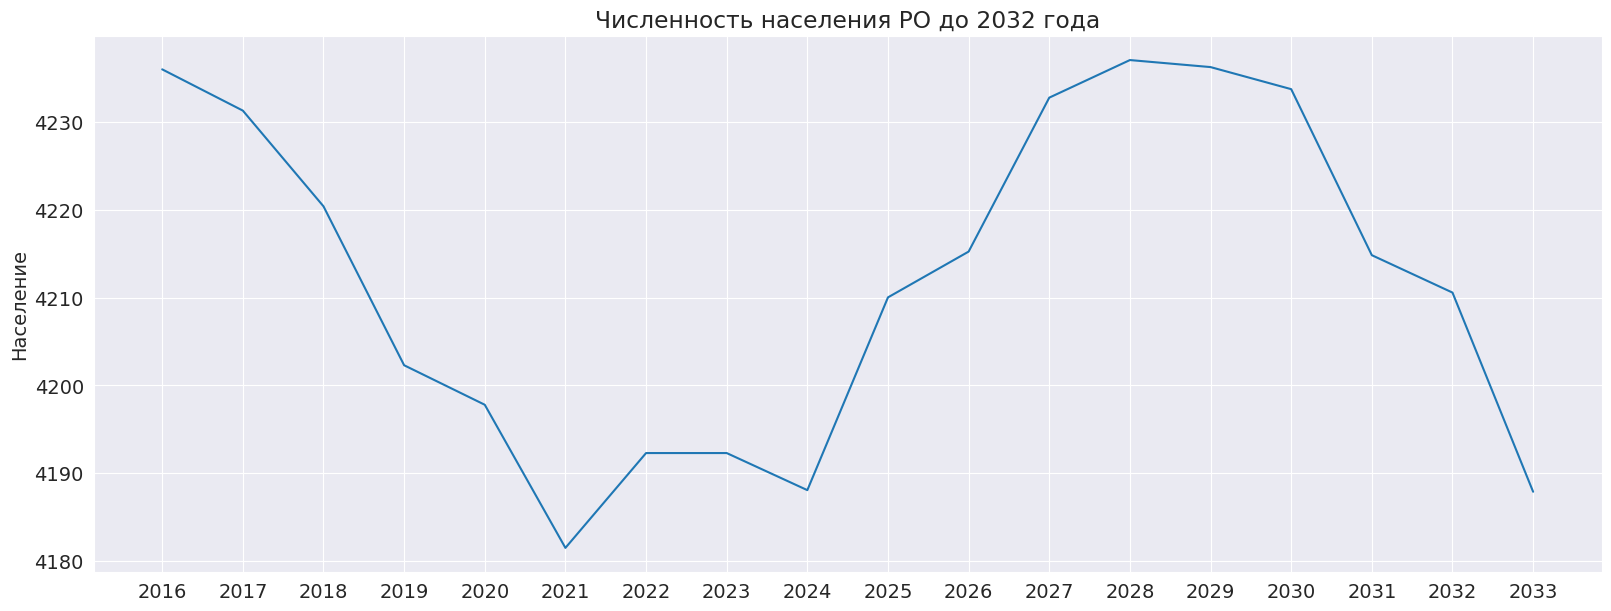

In [425]:
fig, ax = plt.subplots(layout='constrained')
ax.set_title('Численность населения РО до 2032 года')
ax.set_ylabel('Население')
ax.plot(['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033'], values['Total population'])

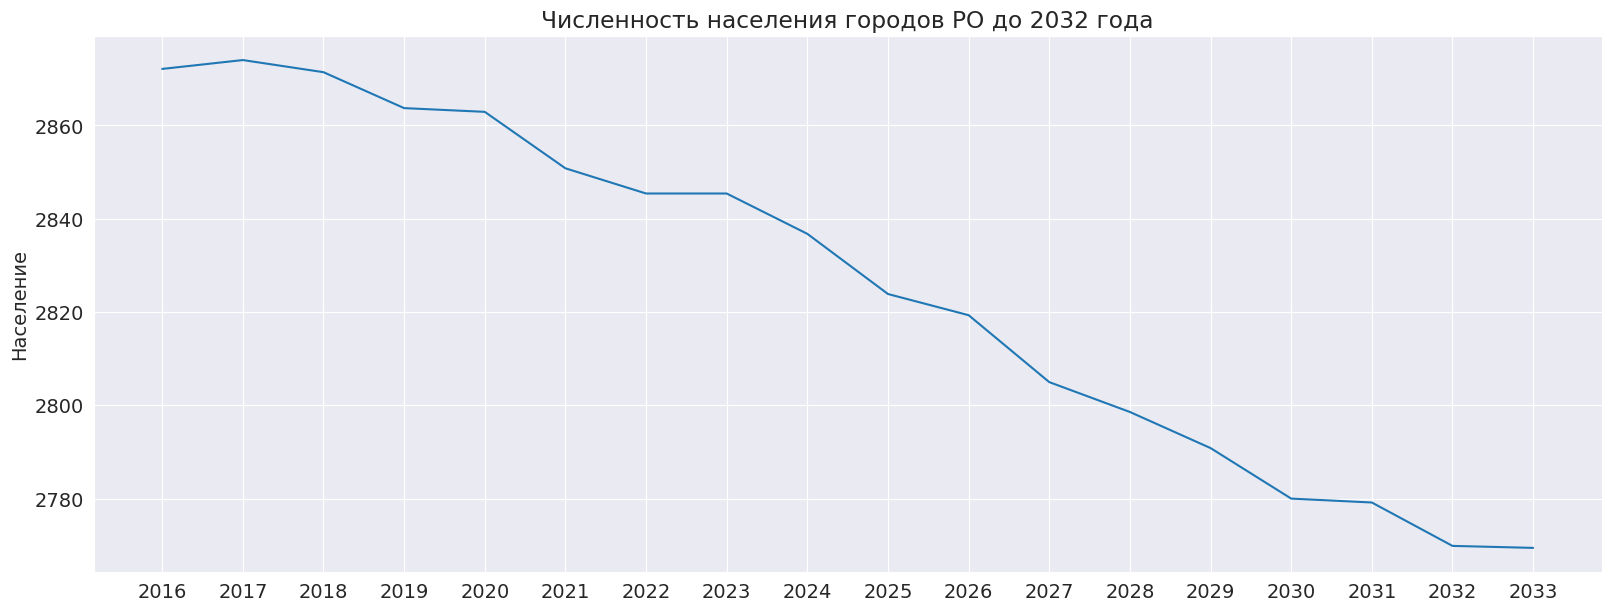

In [426]:
fig, ax = plt.subplots(layout='constrained')
ax.set_title('Численность населения городов РО до 2032 года')
ax.set_ylabel('Население')
ax.plot(['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033'], values['City population'])

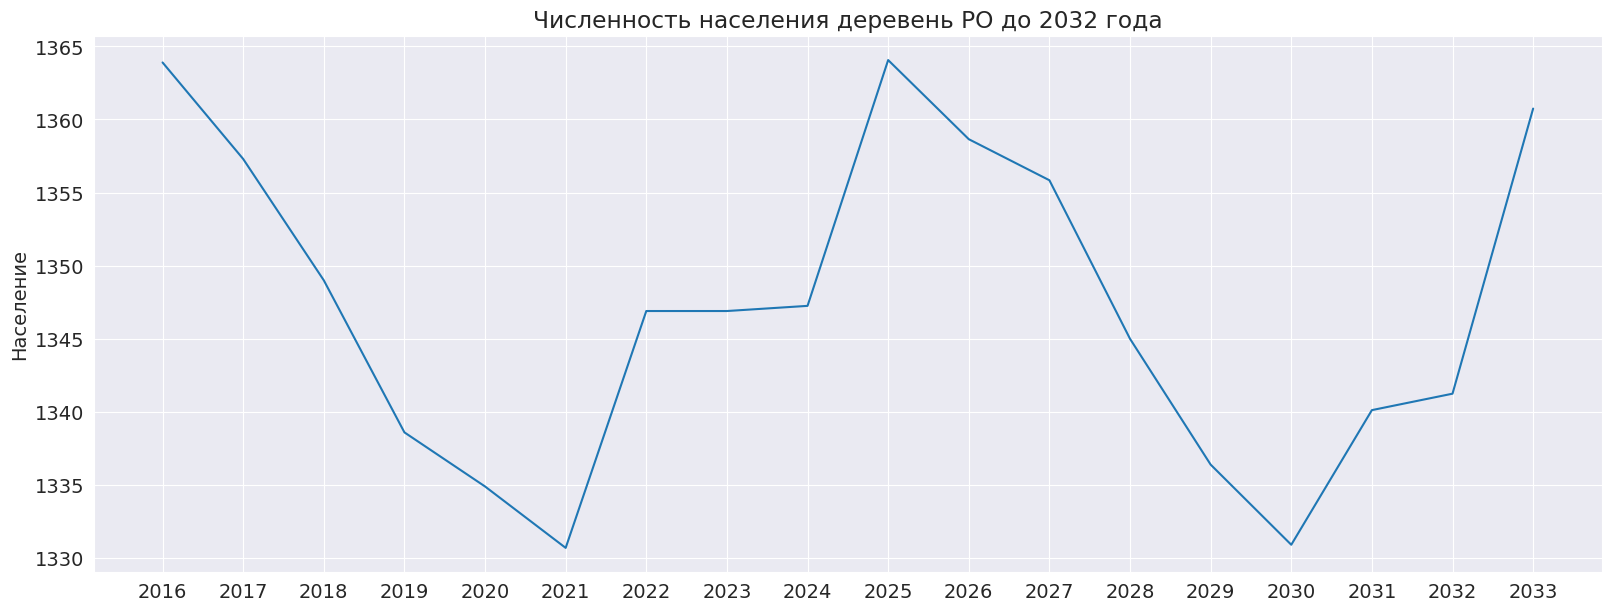

In [427]:
fig, ax = plt.subplots(layout='constrained')
ax.set_title('Численность населения деревень РО до 2032 года')
ax.set_ylabel('Население')
ax.plot(['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033'], values['Village population'])

In [ ]:
# Посмотрим на полученные модели
print(len(trained_arima_models))

331


In [ ]:
# Сохраним каждую из них
with open('models/trained_models.pkl', 'wb') as f:
  pickle.dump(trained_arima_models, f)

In [ ]:
# Убедимся что их можно загрузить
with open('models/trained_models.pkl', 'rb') as f:
  tms = pickle.load(f)
  print(len(tms))

331
